In [1]:
import pandas as pd
import mysql.connector
import os

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='464208464208',
    database='ecommerce'
)
cursor = conn.cursor()



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [3]:
db = mysql.connector.connect(host = 'localhost',
                            username = 'root',
                            password = '464208464208',
                            database = 'ecommerce')
cur = db.cursor()

**1. List all unique cities where customers are located.**

In [5]:
query = """select distinct upper(customer_city) from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['City'])
df

,City
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
...,...
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL


**2. Count the number of orders placed in 2017.**

In [97]:
query = """select FORMAT(count(order_id),0) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

'The total numbers of orders in 2017 is', data[0][0]

('The total numbers of orders in 2017 is', '45,101')

**3. Find the total sales per category.**

In [95]:
query = """SELECT 
                upper(p.product_category),
                FORMAT(ROUND(SUM(pay.payment_value), 1),1) AS 'Total Price'
            FROM order_items oi
            JOIN products p 
            ON oi.product_id = p.product_id
            JOIN payments pay 
            ON oi.order_id = pay.order_id
            GROUP BY p.product_category;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Category','Sales (R$)'])
df

,Category,Sales (R$)
0,PERFUMERY,"506,738.7"
1,FURNITURE DECORATION,"1,430,176.4"
2,TELEPHONY,"486,882.1"
3,BED TABLE BATH,"1,712,553.7"
4,AUTOMOTIVE,"852,294.3"
...,...,...
69,CDS MUSIC DVDS,"1,199.4"
70,LA CUISINE,"2,913.5"
71,FASHION CHILDREN'S CLOTHING,785.7
72,PC GAMER,"2,174.4"


**4. Calculate the percentage of orders that were paid in installments.**

In [12]:
query = """select 
(select count(payment_installments) from payments where payment_installments >= 1)*100
/ count(payment_installments) as 'porcentage payments installs' from payments;"""

cur.execute(query)

data = cur.fetchall()

'The percentage per orders that were paid in installments is', data[0][0]

('The percentage per orders that were paid in installments is',
 Decimal('99.9981'))

**5. Count the number of customers from each state.**

<function matplotlib.pyplot.show(close=None, block=None)>

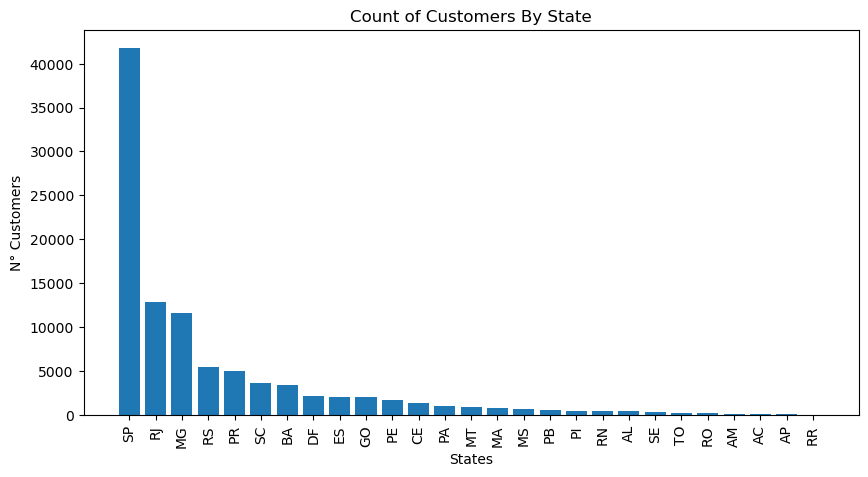

In [14]:
query = """select
                customer_state, 
                count(customer_id) as 'Total customers by state' 
           from customers 
           group by customer_state;"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['State','Total N°Customers'])
df = df.sort_values(by= "Total N°Customers", ascending=False)

plt.figure(figsize=(10,5))
plt.bar(df['State'],df['Total N°Customers'])
plt.xticks(rotation=90)
plt.ylabel(ylabel= 'N° Customers')
plt.xlabel(xlabel= 'States')
plt.title('Count of Customers By State')
plt.show

**6. Calculate the number of orders per month in 2018**

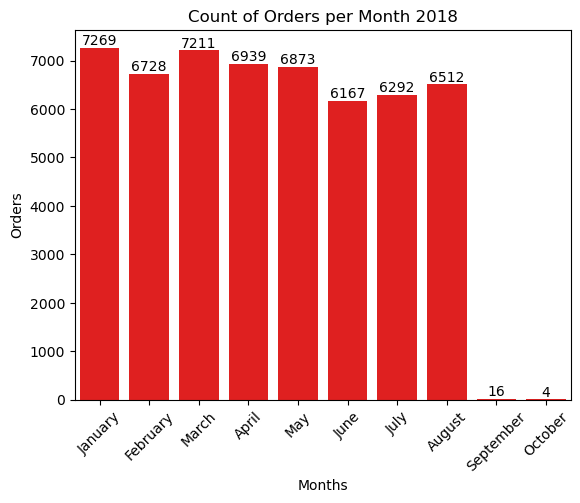

In [16]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) from orders where year(order_purchase_timestamp) = 2018 group by months"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Months','Orders'])
o = ['January','February','March','April','May','June','July','August','September','October']

ax = sns.barplot(x = df['Months'], y = df['Orders'], data = df, order= o, color= 'Red')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title('Count of Orders per Month 2018')
plt.show()

**7. Find the average number of products per order, grouped by customer city.**

In [18]:
query = """with count_per_order as
(SELECT o.order_id, o.customer_id, count(oi.order_id) as oc FROM orders o JOIN order_items oi ON o.order_id = oi.order_id group by o.order_id, o.customer_id)

select upper(customers.customer_city), avg(count_per_order.oc)
from customers join count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;""" 

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['City','Avg Products/Order'])
df

,City,Avg Products/Order
0,SAO PAULO,1.1562
1,SAO JOSE DOS CAMPOS,1.1385
2,PORTO ALEGRE,1.1749
3,INDAIAL,1.1154
4,TREZE TILIAS,1.2727
...,...,...
4105,JAPARATUBA,1.0000
4106,SEBASTIAO LEAL,1.0000
4107,BURITI,3.0000
4108,MORRO AGUDO DE GOIAS,1.0000


**8. Calculate the percentage of total revenue contributed by each product category.**

In [93]:
query = """SELECT 
    upper(p.product_category),
    ROUND(SUM(pay.payment_value) * 100 / (SELECT sum(payment_value) from payments),2)  AS 'Porcentage Total'
    FROM order_items oi
    JOIN products p 
    ON oi.product_id = p.product_id
    JOIN payments pay 
    ON oi.order_id = pay.order_id
    GROUP BY p.product_category order by 'Porcentage Total' desc;"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Category','% Total'])
df

,Category,% Total
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,BED TABLE BATH,10.70
4,AUTOMOTIVE,5.32
...,...,...
69,CDS MUSIC DVDS,0.01
70,LA CUISINE,0.02
71,FASHION CHILDREN'S CLOTHING,0.00
72,PC GAMER,0.01


**9. Identify the correlation between product price and the number of times a product has been purchased.**

In [24]:
query = """select 	upper(products.product_category),
count(order_items.product_id),
round(avg(order_items.price),2)
from products 
JOIN order_items
ON products.product_id = order_items.product_id
group by products.product_category;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Category','Orders','Avg Price'])

arr1 = df['Orders']
arr2 = df['Avg Price']

a = np.corrcoef([arr1,arr2])

print("The correlation between price and the number of times a product is:",a[0][1])

The correlation between price and the number of times a product is: -0.10631514167157562


**10. Calculate the total revenue generated by each seller, and rank them by revenue.**

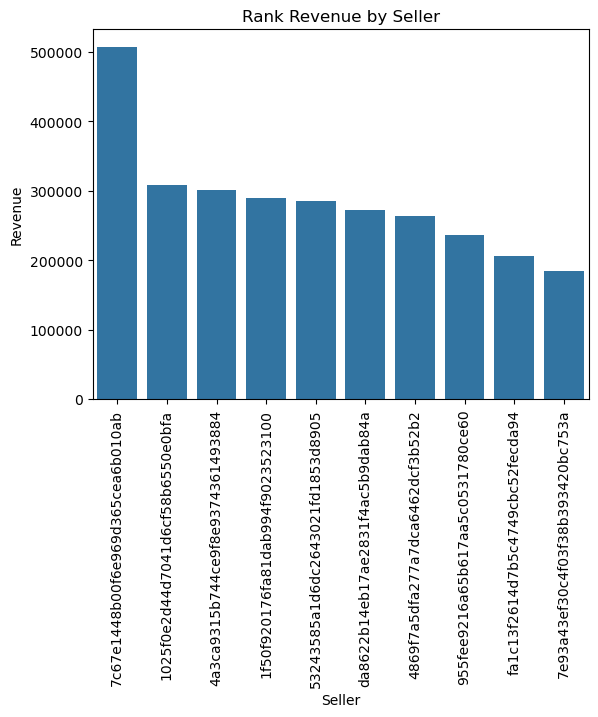

In [27]:
query = """SELECT *, dense_rank() over(order by Revenue desc) as 'Rank' from (SELECT 
                    order_items.seller_id as 'Seller',
                    round(sum(payments.payment_value),1) as Revenue
                FROM
                    payments
                JOIN 
                	order_items
                ON
                	payments.order_id = order_items.order_id
                group by
                	order_items.seller_id) as a;"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Seller','Revenue','Rank'])
df = df.head(10) 
sns.barplot(x = 'Seller', y = 'Revenue', data= df)
plt.xticks(rotation = 90)
plt.title('Rank Revenue by Seller')
plt.show()

**11. Calculate the moving average of order values for each customer over their order history.**

In [67]:
query = """SELECT customer_id, date(order_purchase_timestamp), payment, 
	   round(avg(payment) over(partition by customer_id order by order_purchase_timestamp
       rows between 2 preceding and current row),2) as mov_avg
       from(SELECT 
				orders.customer_id,
				orders.order_purchase_timestamp,
				payments.payment_value as payment
			FROM
				orders
			JOIN
				payments 
			ON 
				orders.order_id = payments.order_id) as a;"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Customer','Time Purchase','Payment (R$)','Mov Avg (R$)'])
filtered_df = df[df['Payment (R$)'] != df['Mov Avg (R$)']]
filtered_df

,Customer,Time Purchase,Payment (R$),Mov Avg (R$)
18,000e943451fc2788ca6ac98a682f2f49,2017-04-20,25.83,26.48
19,000e943451fc2788ca6ac98a682f2f49,2017-04-20,26.80,26.48
26,001051abfcfdbed9f87b4266213a5df1,2018-05-30,32.03,22.69
27,001051abfcfdbed9f87b4266213a5df1,2018-05-30,19.82,21.73
117,004937d0f9d6ce15c2830c00c2f482e5,2018-01-27,6.96,35.46
...,...,...,...,...
103792,ffbf82fe167e7156e06fc1778d6b1cea,2017-08-05,89.46,39.41
103862,fff3a5c6d542d52b05f7e4518adf996e,2018-02-18,5.33,24.98
103863,fff3a5c6d542d52b05f7e4518adf996e,2018-02-18,33.27,27.74
103880,fffecc9f79fd8c764f843e9951b11341,2018-03-29,71.23,35.94


**12. Calculate the cumulative sales per month for each year.**

In [87]:
query = """SELECT years, months,FORMAT(payment,2), FORMAT((ROUND(sum(Payment)
OVER (ORDER BY years, months))),1) as 'Cumulative Sales' from
(SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
    ROUND(SUM(payments.payment_value),2) as Payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY years, months
ORDER BY years, months) AS a;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Years','Months','Payment (R$)','Cumulative Sales (R$)'])
df

,Years,Months,Payment (R$),Cumulative Sales (R$)
0,2016,9,252.24,252.0
1,2016,10,"59,090.48","59,343.0"
2,2016,12,19.62,"59,362.0"
3,2017,1,"138,488.04","197,850.0"
4,2017,2,"291,908.01","489,758.0"
5,2017,3,"449,863.60","939,622.0"
6,2017,4,"417,788.03","1,357,410.0"
7,2017,5,"592,918.82","1,950,329.0"
8,2017,6,"511,276.38","2,461,605.0"
9,2017,7,"592,382.92","3,053,988.0"


**13. Calculate the year-over-year growth rate of total sales.**

In [34]:
query = """SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value),2) as Payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY years
ORDER BY years;"""

cur.execute(query)

data = cur.fetchall()

y2016 = data[0][1]
y2017 = data[1][1]
y2018 = data[2][1]

growth_year_2016_2017 = round(((y2017-y2016)/y2016)*100)

growth_year_2017_2018 = round(((y2018-y2017)/y2017)*100)

print(f"The interannual growth of 2017 compared to 2016 is: %{growth_year_2016_2017}\nThe interannual growth of 2018 compared to 2017 is: %{growth_year_2017_2018}")

The interannual growth of 2017 compared to 2016 is: %12113
The interannual growth of 2018 compared to 2017 is: %20


**14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.**

In [45]:
query = """with a as (SELECT customers.customer_id,
	   min(orders.order_purchase_timestamp) first_order
       from customers join orders
       on customers.customer_id = orders.customer_id
       group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order	
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)

data = cur.fetchall()

print('None of the regular customers repeat themselves, which is why the query in the database returns "none".')

None of the regular customers repeat themselves, which is why the query in the database returns "none".


**15. Identify the top 3 customers who spent the most money in each year.**

In [107]:
query = """select years, customer_id, FORMAT(round(payment),1), d_rank
from (select year(orders.order_purchase_timestamp) years,
	   orders.customer_id,
       sum(payments.payment_value) payment,
       dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
	from
		orders
	join
		payments
	on orders.order_id = payments.order_id
	group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_rank <= 3;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['Years','Customer','Payment (R$)','Rank'])
df

,Years,Customer,Payment (R$),Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,"1,424.0",1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,"1,401.0",2
2,2016,4a06381959b6670756de02e07b83815f,"1,228.0",3
3,2017,1617b1357756262bfa56ab541c47bc16,"13,664.0",1
4,2017,c6e2731c5b391845f6800c97401a43a9,"6,929.0",2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,"6,727.0",3
6,2018,ec5b2ba62e574342386871631fafd3fc,"7,275.0",1
7,2018,f48d464a0baaea338cb25f816991ab1f,"6,922.0",2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,"4,809.0",3
